In [16]:
#Visualize housing splits and accuracy on map.
#Setup caffe
import os 
caffe_root='/scr/r6/tgebru/timnit_caffe'

import sys
sys.path.insert(0, os.path.join(caffe_root,'python'))

import caffe
import numpy as np
import pickle

net_root='/scr/r6/tgebru/timnit_caffe/timnit_models/\
ny_housing/classify/'
net_name=os.path.join(net_root,'deploy.prototxt')
model=os.path.join(net_root,'snapshot/_iter_140000.caffemodel')
net=caffe.Net(net_name,model,caffe.TEST)

#Preprocess input
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load(os.path.join(caffe_root, 
            'python/caffe/imagenet/ilsvrc_2012_mean227.npy')).mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

#set net to batch size of 100
BATCH_SIZE=100
net.blobs['data'].reshape(BATCH_SIZE,3,227,227)

In [79]:
data_root='/scr/r6/tgebru/timnit_caffe/data/ny_housing'
train_files=os.path.join(data_root,'housing_2013_class_train.txt')
val_files=os.path.join(data_root,'housing_2013_class_val.txt')
test_files=os.path.join(data_root,'housing_2013_class_test.txt')


caffe.set_device(0)
caffe.set_mode_gpu()
train_lines=open(train_files,'rb').readlines()
val_lines=open(val_files,'rb').readlines()
test_lines=open(test_files,'rb').readlines()


In [90]:
#1. Do forward pass of trainig and testidata
def do_forward(lines,pname,feat_pname,feat,net):
    if os.path.exists(pname):
        print 'loading from pickle file %s'%pname
        with open(pname,'rb') as f:
            predicted=pickle.load(f)
            return predicted
    import time
    iter=0
    b=0
    predicted=[]
    features=[]
    s=time.time()
    #Do forward prop
    for l in lines:
      fname=l.split(' ')[0]
      if b % BATCH_SIZE==0:
        print 'Processing %d out of %d'%(iter,len(lines))
        b=0
      net.blobs['data'].data[b,:,:,:]=\
        transformer.preprocess('data', 
                    caffe.io.load_image('/'+fname))
      if b==BATCH_SIZE-1 or iter==len(lines)-1:
        out=net.forward()
        predicted.extend([net.blobs['prob'].data[i].flatten().argsort()[-1:-6:-1][0]
               for i in xrange(b+1)])
        #Save features
        features.extend(net.blobs[feat].data)
      iter += 1
      b+=1
    print time.time()-s

    with open(pname,'wb') as f:
        pickle.dump(predicted,f)
    with open(feat_pname,'wb') as f:
        pickle.dump(features,f)
        
    return predicted

In [ ]:
#Train SVM with fc7 features

In [68]:
#Create (lat,lng,actual,predicted) tuple
def calculate_acc(lines,predicted):
    labels=[]
    iter=0
    acc=0
    for l in lines:
      fname=l.split(' ')[0]
      lat=fname.split('/')[-1].split('_')[0]
      lng=fname.split('/')[-1].split('_')[1]
      actual=l.split(' ')[1].strip()
      labels.append((lat,lng,actual,predicted[iter]))
      if int(actual)==int(predicted[iter]):
        acc += 1
      iter += 1
    acc /=float(len(lines))
    return acc,labels


In [91]:
FEAT='fc7'
train_pname='/imagenetdb3/tgebru/cvpr2016/housing_train_2013_class_cnn.pickle'
val_pname='/imagenetdb3/tgebru/cvpr2016/housing_val_2013_class_cnn.pickle'
train_feat_pname='/imagenetdb3/tgebru/cvpr2016/housing_train_2013_class_%s.pickle'%FEAT
val_feat_pname='/imagenetdb3/tgebru/cvpr2016/housing_val_2013_class_%s.pickle'%FEAT


train_predicted=do_forward(train_lines,train_pname,
                           train_feat_pname,FEAT,net)
val_predicted=do_forward(val_lines,val_pname,
                         val_feat_pname,FEAT,net)


train_acc,train_labels=calculate_acc(train_lines,train_predicted)
val_acc,val_labels=calculate_acc(val_lines,val_predicted)

print 'train acc=%f'%train_acc
print 'val acc=%f'%val_acc

loading from pickle file /imagenetdb3/tgebru/cvpr2016/housing_train_2013_class_cnn.pickle
loading from pickle file /imagenetdb3/tgebru/cvpr2016/housing_val_2013_class_cnn.pickle
train acc=0.767829
val acc=0.338760


In [46]:
#Accuracy by class
def get_class_acc(labels,num_classes):
    class_nums=np.zeros(num_classes)
    class_accs=np.zeros(num_classes)

    for l in labels:
      actual=l[2]
      predicted=l[3]
      class_nums[actual] +=1

      if int(actual)==int(predicted):
          class_accs[actual] +=1

    class_acc = np.divide(class_accs,class_nums)
    
    #bar plot
    fig,ax=plt.subplots()
    rects1 = ax.bar(xrange(num_classes),class_acc)
    rects2 = ax.bar(xrange(num_classes),class_nums/sum(class_nums), 0.5, color='y')

    ax.set_xticks(xrange(num_classes))
    ax.set_xticklabels(xrange(num_classes))

    ax.set_xlabel('Class')
    ax.set_ylabel('Acc')
    ax.set_title('Acc by class')
    plt.show()
    return class_acc,class_nums

In [ ]:
#Train an SVM using features from CNN
sys.path.insert(0, '/scr/r6/tgebru/tools/liblinear-2.1/python')

from liblinearutil import *
if not train_feats:
    print 'loading train features'
    with open(train_feat_pname,'rb') as f:
        train_feats = pickle.load(f)

if not val_feats:
    print 'loading val features'
    with open(val_feat_pname,'rb') as f:
        val_feats = pickle.load(f)

labels=[]
for l in train_lines:
    fname=l.split(' ')[0]
    labels.append(int(l.split(' ')[1].strip()))

feat_list=[f.tolist() for f in train_feats[0:len(labels)]]
           
print 'training model...'
m = train(labels, feat_list, '-c 4')

print 'evaluating model...'
p_label, p_acc, p_val = predict(labels,feat_list, m)
#save_model('/imagenetdb3/tgebru/cvpr2016/housing_val_2013_class_%s.model'%FEAT')

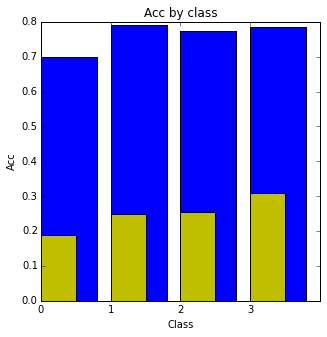

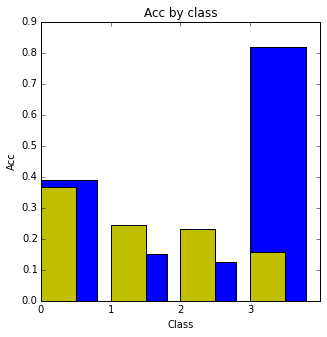

[ 0.69779736  0.79017264  0.77504848  0.78641644] [ 3405.  4518.  4641.  5595.]
[ 0.38988327  0.15087719  0.12655087  0.81801802] [ 1285.   855.   806.   555.]


In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=(5,5)

train_class_acc,train_class_nums=get_class_acc(train_labels,4)
val_class_acc,val_class_nums=get_class_acc(val_labels,4)

print train_class_acc,train_class_nums
print val_class_acc, val_class_nums

(-74.299999999999997,
 -73.599999999999994,
 40.400000000000006,
 41.000000000000007)

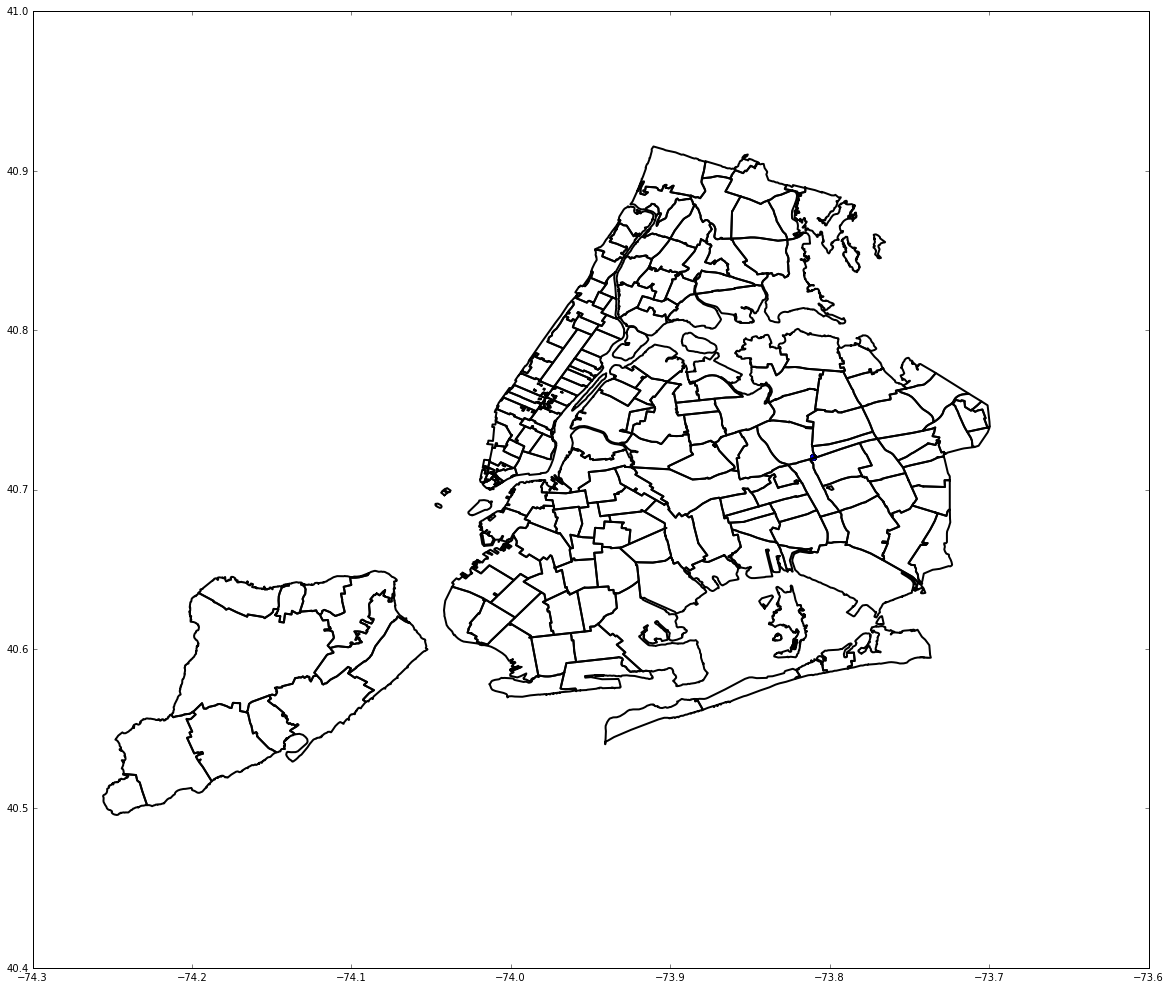

In [80]:
#Map Values
import json 

plt.rcParams['figure.figsize']=(20,20)


#Map zipcode boundaries
fname='/imagenetdb3/tgebru/cvpr2016/housing_shapefiles/\
nyc-zip-code-tabulation-areas-polygons.geojson'
with open(fname) as json_file:
    json_data=json.load(json_file)

x_list=[]
y_list=[]
 
#Plot train coordinates of lat/lngs
fig = plt.figure() 
ax = fig.gca()

#plot train coordinates of lat/lngs
for tr in train_labels:
    ax.plot(tr[1],tr[0],'ro',alpha=0.5)

#plot val coordinates of lat/lngs
for val in val_labels:
    ax.plot(val[1],val[0],'go',alpha=0.5)
    
#plot test coordinates of lat/lngs
for t in test_lines:
    fname=l.split(' ')[0]
    lat=fname.split('/')[-1].split('_')[0]
    lng=fname.split('/')[-1].split('_')[1]
    ax.plot(lng,lat,'bo',alpha=0.5)
    
#Plot zipcode boundaries
for feat in json_data['features']:
    coords = feat['geometry']['coordinates'] 
    x_list.append([i for i,j in coords[0]])
    y_list.append([j for i,j in coords[0]])

for x,y in zip(x_list,y_list):
    ax.plot(x,y,'k',linewidth=2.0)
ax.axis('scaled')

In [86]:
for t in test_lines:
    fname=l.split(' ')[0]
    lat=fname.split('/')[-1].split('_')[0]
    lng=fname.split('/')[-1].split('_')[1]
    ax.plot(lng,lat,'bo',alpha=0.5)

timni
